In [1]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math


In [2]:
data_directory = "../data/curated/"
merchants = pd.read_parquet(data_directory + "merchants.parquet")
transactions = pd.read_parquet(data_directory + "transactions.parquet")
consumers = pd.read_parquet(data_directory + "consumers.parquet")
census = pd.read_csv(data_directory + "census.csv")

# spark = (SparkSession.builder.appName("MAST30034 Ass2 Preprocess")
#     .config("spark.sql.parquet.cacheMetadata", "true")
#     .config("spark.sql.session.timeZone", "Etc/UTC")
#     .config('spark.executor.memory', '8g')
#     .config("spark.sql.execution.arrow.pyspark.enabled", "true")
#     .config("spark.sql.repl.eagerEval.enabled", True) 
#     .getOrCreate()
# )

# pd.set_option('compute.ops_on_diff_frames', True)

In [3]:
census.head()

,postcode,nill_income_percent_F,nill_income_percent_M,house_repay_to_income,Median_age_persons,high_income_proportion,Median_mortgage_repay_monthly
0,2000,0.109385,0.072277,0.290406,32.0,0.183133,2800.0
1,2007,0.130626,0.096731,0.319625,30.0,0.122807,2500.0
2,2008,0.158961,0.126999,0.343643,28.0,0.156635,2600.0
3,2009,0.082974,0.047567,0.266785,37.0,0.251541,2800.0
4,2010,0.043674,0.031714,0.291350,36.0,0.299588,2900.0


In [4]:
merchants.head()

,name,tags,sector_tags,revenue_band,take_rate
merchant_abn,,,,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",e,0.18
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...","cable, satellite, and other pay television and...",b,4.22
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, and silverware shops",b,4.40
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...","watch, clock, and jewelry repair shops",b,3.29
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...","music shops - musical instruments, pianos, and...",a,6.33


In [5]:
user_counts = transactions.merge(merchants.reset_index()).groupby(["merchant_abn", "user_id"]).agg(count=("order_id", "count")).reset_index()

In [6]:
user_counts

,merchant_abn,user_id,count
0,10023283211,8,2
1,10023283211,15,1
2,10023283211,19,1
3,10023283211,22,1
4,10023283211,31,1
...,...,...,...
7859069,99990536339,21308,1
7859070,99990536339,21352,1
7859071,99990536339,23299,1
7859072,99990536339,23730,1


In [7]:
#Total number of customers returning
len(user_counts[user_counts["count"] > 1])/len(user_counts)

0.2687964256348776

In [8]:
pd.options.mode.chained_assignment = None

# TODO: make more efficient using groupby-apply?
# retention = (Customers End - Customers New) / Customers Start
def customer_retention(merchant_abn, transactions, month_period):
    def month_diff(d1, d2):
        return (d1.year - d2.year) * 12 + d1.month - d2.month
    
    def new_customers(aggregated, period):
        new = aggregated[aggregated["date_segment"] == period]["user_id"]
        old = aggregated[aggregated["date_segment"] == period + 1]["user_id"]
        
        return len(set(new) - set(old))
        
    # filter for specific merchant
    transactions = transactions.loc[transactions["merchant_abn"] == merchant_abn]
    
    if len(transactions) == 0:
        return []
    
    latest_date = max(transactions["order_datetime"])
    transactions["date_segment"] = transactions["order_datetime"].apply(lambda x: month_diff(latest_date, x) // month_period)
    max_segment = max(transactions["date_segment"])
    
    # aggregate by customer-timescale for specific merchant to get customers active within the timeframes
    aggregate_by = ["user_id", "date_segment"]
    aggregated_transactions = transactions.groupby(aggregate_by).count().add_suffix('_Count').reset_index()[aggregate_by]
    
    n_cust = lambda x: len(aggregated_transactions[aggregated_transactions["date_segment"] == x])

    retentions = [0 if n_cust(i+1) == 0 else (n_cust(i) - new_customers(aggregated_transactions, i))/n_cust(i+1) for i in range(0, max_segment - 1)]
    
    return retentions

In [9]:
retention = merchants.reset_index()
transactions["order_datetime"] = pd.to_datetime(transactions["order_datetime"])
retention["retention"] = retention["merchant_abn"].apply(lambda x: np.mean(customer_retention(x, transactions, 6) or [0]))
retention = retention.sort_values("retention", ascending=False)
retention


,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention
680,24852446429,Erat Vitae LLP,"[(florists supplies, nursery stock, and floWer...","florists supplies, nursery stock, and flowers",c,2.94,0.974772
3443,86578477987,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...","watch, clock, and jewelry repair shops",a,6.43,0.969074
2439,64203420245,Pede Nonummy Corp.,"((tent and awning shops), (c), (take rate: 2.86))",tent and awning shops,c,2.86,0.967014
1827,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,a,5.80,0.959858
1694,46804135891,Suspendisse Dui Corporation,"((opticians, optical goods, and eyeglasses), (...","opticians, optical goods, and eyeglasses",c,2.93,0.945167
...,...,...,...,...,...,...,...
814,27529271582,Pharetra Ltd,"([hobby, toy and game shops], [b], [take rate...","hobby, toy and game shops",b,4.70,0.000000
815,27573216953,Adipiscing Inc.,"((tent and awning shops), (a), (take rate: 6.82))",tent and awning shops,a,6.82,0.000000
817,27580593799,Gravida Praesent Incorporated,"[(bicycle shops - sales and service), (c), (ta...",bicycle shops - sales and service,c,1.58,0.000000
2399,63442187477,Vestibulum Lorem Corp.,"[(hobby, toy and game shops), (b), (take rate:...","hobby, toy and game shops",b,3.41,0.000000


<AxesSubplot:xlabel='retention', ylabel='Density'>

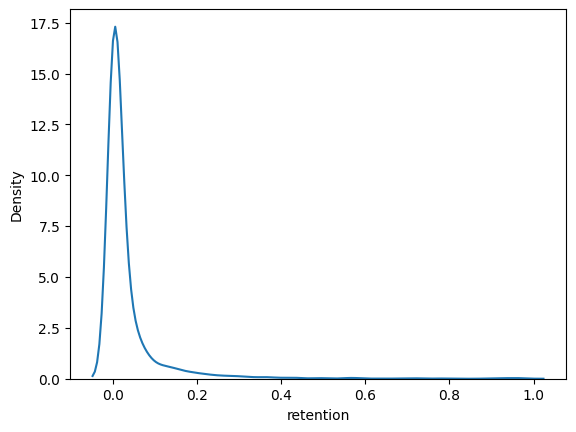

In [10]:
import seaborn as sns
sns.kdeplot(retention["retention"])

In [11]:
transactions.head()

,user_id,merchant_abn,dollar_value,order_id,order_datetime
index,,,,,
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28


Momemtum calculations are SMA(n) - SMA(n-1)

In [12]:

transactions["month"] = pd.DatetimeIndex(transactions['order_datetime']).year * 12 + pd.DatetimeIndex(transactions['order_datetime']).month
transaction_momentum = transactions.groupby(["merchant_abn", "month"]).agg(monthly_revenue=("dollar_value", sum)).reset_index()
transactions_groupby = transaction_momentum.groupby("merchant_abn")


In [13]:
sma_periods = [3, 5, 9]
col_names = [f"{sma_period}-month-sma" for sma_period in sma_periods]
diff_col_names = [f"{sma_period}-month-sma-diff" for sma_period in sma_periods]




for i, sma_period in enumerate(sma_periods):
    transaction_momentum[col_names[i]] = transactions_groupby.rolling(window=sma_period, on="month").mean().reset_index(drop=True).fillna(0)["monthly_revenue"]

transaction_momentum[diff_col_names] = transaction_momentum.sort_values(["merchant_abn", "month"]).groupby("merchant_abn").diff().fillna(0)[col_names]

transaction_momentum[transaction_momentum["merchant_abn"] == 64403598239]

,merchant_abn,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff
46177,64403598239,24254,10937.456258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46178,64403598239,24255,338347.821721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46179,64403598239,24256,352336.111639,233873.796539,0.000000,0.000000,233873.796539,0.000000,0.000000
46180,64403598239,24257,388855.955456,359846.629605,0.000000,0.000000,125972.833066,0.000000,0.000000
46181,64403598239,24258,391785.664744,377659.243946,296452.601964,0.000000,17812.614341,296452.601964,0.000000
46182,64403598239,24259,403474.048181,394705.222794,374959.920348,0.000000,17045.978847,78507.318385,0.000000
46183,64403598239,24260,434607.749826,409955.820917,394211.905969,0.000000,15250.598124,19251.985621,0.000000
46184,64403598239,24261,419471.790642,419184.529550,407639.041770,0.000000,9228.708632,13427.135800,0.000000
46185,64403598239,24262,467747.697161,440609.079209,423417.390111,356396.032847,21424.549660,15778.348341,356396.032847
46186,64403598239,24263,604153.962318,497124.483373,465891.049625,422308.977965,56515.404164,42473.659515,65912.945118


In [14]:
revenue_and_momentum = transaction_momentum.groupby("merchant_abn").last().reset_index()

Next up, a transaction volume/total revenue model. We assume that the distribution of transaction amount remains relatively constant over time for each merchant for this model.

In [15]:

counts = transactions.groupby(["merchant_abn", "order_datetime"]).agg(count=("dollar_value", "count")).reset_index().groupby("merchant_abn").agg(volume_mean=("count", "mean"), volume_stdev=("count", "std"))
counts = pd.concat([counts, transactions.groupby(["merchant_abn"]).agg(amount_mean=("dollar_value", "mean"), amount_stdev=("dollar_value", "std"))], axis=1).reset_index()
counts

,merchant_abn,volume_mean,volume_stdev,amount_mean,amount_stdev
0,10023283211,5.203642,2.477076,205.303007,119.576733
1,10142254217,4.823826,2.420675,33.174818,28.016261
2,10165489824,1.000000,0.000000,11310.946039,8097.733445
3,10187291046,1.337449,0.669060,109.651782,68.457302
4,10192359162,1.347170,0.633833,406.163771,266.330684
...,...,...,...,...,...
4016,99938978285,27.250825,8.000607,25.271654,21.262586
4017,99974311662,1.126126,0.384167,271.896210,180.255675
4018,99976658299,36.945545,9.905104,142.369527,74.872157
4019,99987905597,1.224490,0.507423,322.171365,147.700470


Here's what we've got to rank people now. The coefficients were somewhat arbitrarily decided such that they had a sufficient effect on the ranking, they should be tuned. We need to introduce some more features as well.

In [16]:
ranking = retention.reset_index().merge(counts).merge(revenue_and_momentum).fillna(0)
ranking["score"] = ranking["9-month-sma"].multiply(ranking["take_rate"].astype(float))/100 + 0.5 * (ranking["9-month-sma-diff"] + ranking["5-month-sma-diff"] + ranking["3-month-sma-diff"]) + 50 * (ranking["volume_mean"] - ranking["volume_stdev"]) + ranking["retention"] * 10000
ranking.sort_values("score", ascending=False)

,index,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
1,3443,86578477987,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...","watch, clock, and jewelry repair shops",a,6.43,0.969074,432.752475,92.659698,...,20.369845,24274,434977.272602,475018.083602,471907.857718,437537.759507,-13897.045176,-4212.944104,11318.607018,51433.370601
6,3590,89726005175,Est Nunc Consulting,"((tent and awning shops), (a), (take rate: 6.01))",tent and awning shops,a,6.01,0.937467,345.239274,74.897774,...,20.606519,24274,436865.217694,464480.016927,456988.778588,422986.627211,-6568.950580,-648.814843,13388.339141,51398.524302
3,1827,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,a,5.80,0.959858,405.894389,88.120121,...,15.015012,24274,376706.982550,399425.500200,396902.765788,367188.851890,-9175.598659,-2183.251875,11708.035915,46958.841607
12,2446,64403598239,Lobortis Ultrices Company,"((music shops - musical instruments, pianos, a...","music shops - musical instruments, pianos, and...",a,6.31,0.773982,186.026403,40.801952,...,41.603827,24274,462967.512974,495091.891712,486456.962210,450478.851698,-7596.977380,-615.761867,13100.679339,45870.227856
5,1637,45629217853,Lacus Consulting,"[[gift, Card, novelty, and souvenir shops], [a...","gift, card, novelty, and souvenir shops",a,6.98,0.941081,356.186469,79.449614,...,26.233846,24274,346471.636195,375390.376775,372288.459904,345427.877314,-10418.876174,-3420.067596,9938.539158,45408.317353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,199,14530561097,Duis At Inc.,"[[jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, and silverware shops",c,1.69,0.000000,1.100840,0.302390,...,5207.957419,24274,62458.311777,37731.581208,56447.781618,52894.870058,-9355.050336,-7919.272778,-1904.164535,-8655.398024
1801,1349,39192981624,Eu Eros LLC,"([furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",b,3.29,0.008333,1.369863,0.658163,...,1037.883682,24274,28130.736966,42323.611391,52490.542652,45197.535008,-15735.861254,-4130.616833,-671.370902,-8663.007238
3066,1092,33364563448,Lacinia Orci Incorporated,"([antique shops - sales, repairs, and restorat...","antique shops - sales, repairs, and restoratio...",b,4.99,0.000000,1.090909,0.291937,...,6825.234267,24274,5138.533447,18307.144970,23319.771097,21072.572837,-12227.342136,-5970.286877,-2453.511893,-9234.100469
2949,3629,90918180829,Pharetra Quisque Company,"([jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, and silverware shops",c,2.62,0.000000,1.369128,0.628707,...,5241.851423,24274,181862.853334,223028.583138,233190.242852,212438.554029,-28319.610656,-18459.305153,7004.546204,-14284.273667


In [17]:
merchant_groupings = {
    "tent and awning shops": "Miscellaneous Stores",
    "gift, card, novelty, and souvenir shops": "Miscellaneous Stores",
    "digital goods: books, movies, music": "Miscellaneous Stores",
    "watch, clock, and jewelry repair shops": "Miscellaneous Stores",
    "cable, satellite, and other pay television and radio services": "Utility services",
    "florists supplies, nursery stock, and flowers": "Retail outlet services",
    "opticians, optical goods, and eyeglasses": "Professional services and membership organisations",
    "computers, computer peripheral equipment, and software": "Retail outlet services",
    "computer programming , data processing, and integrated systems design services": "Business Services",
    "furniture, home furnishings and equipment shops, and manufacturers, except appliances": "Miscellaneous Stores",
    "artist supply and craft shops": "Miscellaneous Stores",
    "shoe shops": "Retail outlet services",
    "books, periodicals, and newspapers": "Retail outlet services",
    "lawn and garden supply outlets, including nurseries": "Retail outlet services",
    "music shops - musical instruments, pianos, and sheet music": "Miscellaneous Stores",
    "motor vehicle supplies and new parts": "Retail outlet services",
    "health and beauty spas": "Miscellaneous Stores",
    "hobby, toy and game shops": "Miscellaneous Stores",
    "bicycle shops - sales and service": "Miscellaneous Stores",
    "antique shops - sales, repairs, and restoration services": "Miscellaneous Stores",
    "stationery, office supplies and printing and writing paper": "Retail outlet services",
    "equipment, tool, furniture, and appliance rent al and leasing": "Business Services",
    "telecom": "Utility services",
    "art dealers and galleries": "Miscellaneous Stores",
    "jewelry, watch, clock, and silverware shops": "Miscellaneous Stores"
}

In [18]:
for grouping in set(merchant_groupings.values()):
    print(grouping)
    tags_list = [i for i in merchant_groupings.keys() if merchant_groupings[    i] == grouping]
    display(ranking[ranking["sector_tags"].isin(tags_list)].sort_values("score", ascending=False).head())
    

Utility services


,index,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
11,519,21439773999,Mauris Non Institute,"([cable, satellite, and other pay television a...","cable, satellite, and other pay television and...",a,6.10,0.781058,191.618812,42.614492,...,45.507240,24274,446528.038817,470088.077343,467740.703846,432846.061180,-8626.503955,153.150100,13564.802034,44210.126269
510,3268,82368304209,Nec Incorporated,"[[telecom], [a], [take rate: 5.55]]",telecom,a,5.55,0.065200,7.481848,3.086441,...,1163.866374,24274,400995.964291,425817.909415,410497.081765,379263.998535,-1454.522165,-2987.705984,11463.359362,25431.485024
54,348,17488304283,Posuere Cubilia Curae Corporation,"((cable, satellite, and other pay television a...","cable, satellite, and other pay television and...",a,6.18,0.353735,54.011551,13.673943,...,52.933686,24274,156503.353350,168960.194848,168331.442840,155990.349521,-5042.238905,-1490.424019,4326.938559,14091.572168
1004,3737,93260930990,Pede Cras Vulputate Ltd,"[[telecom], [b], [take rate: 3.15]]",telecom,b,3.15,0.026236,3.517827,1.915326,...,1873.944287,24274,367629.546299,405784.638861,394526.512423,362713.781421,-7982.421360,4748.527482,6393.010095,13347.529440
58,900,29521780474,At Sem Corp.,"((cable, satellite, and other pay television a...","cable, satellite, and other pay television and...",a,5.93,0.346358,52.072607,13.325847,...,28.028759,24274,53881.531661,58179.336703,57843.372147,53826.291731,-1251.751689,-308.442738,1528.127826,8576.781722


Business Services


,index,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
46,1214,35909341340,Arcu Sed Eu Incorporated,"[(computer programming , data processing, and ...","computer programming , data processing, and in...",b,4.80,0.378962,60.000000,14.995096,...,132.435948,24274,448644.687693,480286.272707,472794.674419,437619.368141,-13668.948257,-2559.494339,12719.996292,25291.374322
89,3053,77590625261,Sed Diam Foundation,"((computer programming , data processing, and ...","computer programming , data processing, and in...",b,3.24,0.272579,39.724422,10.661507,...,147.663590,24274,371072.983776,392360.584983,377112.074519,354222.655055,3529.569080,-2693.740201,12912.696415,22530.014046
45,2582,67400260923,Eleifend PC,"[(computer programming , data Processing, and ...","computer programming , data processing, and in...",a,5.97,0.381612,59.155116,14.989441,...,95.498979,24274,251997.563155,265545.358182,265857.148960,246295.813052,-7082.601714,1279.606759,6829.616886,21241.570467
85,2193,58454491168,Diam At Foundation,"([computer programming , datA processing, and ...","computer programming , data processing, and in...",a,6.01,0.281468,42.075908,10.490177,...,132.634456,24274,290471.662202,330388.071202,326878.752028,307058.149838,-10988.876502,-5489.186428,6532.537844,17875.400663
1534,2896,74093231988,Mi Eleifend Company,"((equipment, tool, furniture, and appliance re...","equipment, tool, furniture, and appliance rent...",a,5.62,0.011926,2.160677,1.228017,...,785.335703,24274,72484.077581,62104.643091,57735.939123,51732.907397,10303.596365,3408.293954,4073.812700,11966.136667


Retail outlet services


,index,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
7,1533,43186523025,Lorem Ipsum Sodales Industries,"([florists supplies, nurSery stock, and flower...","florists supplies, nursery stock, and flowers",b,4.47,0.922655,321.033003,70.625509,...,22.372564,24274,434155.152665,467532.579883,464016.270480,427643.584920,-11687.724491,-2289.970647,11792.032473,39769.766550
0,680,24852446429,Erat Vitae LLP,"[(florists supplies, nursery stock, and floWer...","florists supplies, nursery stock, and flowers",c,2.94,0.974772,459.841584,98.377858,...,17.440433,24274,403664.968898,434776.257269,429782.757876,398298.922312,-9862.285409,-2468.842800,10589.629726,38660.146578
10,2620,68216911708,Placerat Eget Venenatis Limited,"[[computers, computer peripheral equipment, an...","computers, computer peripheral equipment, and ...",c,3.05,0.897159,285.570957,61.904732,...,24.742530,24274,308027.691426,334184.770120,333377.271407,308841.653962,-10274.315350,-2637.321180,8135.562305,27186.535693
709,987,31385641294,Semper Auctor PC,"[(motor vehicle supplies and new parts), (b), ...",motor vehicle supplies and new parts,b,4.52,0.044294,5.466777,2.493197,...,1321.872552,24274,350843.459264,354709.169537,350224.086028,320722.689572,2595.993673,4478.677945,15804.911038,26528.074365
154,1624,45433476494,Adipiscing Elit Foundation,"[[computers, computer peripheral equipment, a...","computers, computer peripheral equipment, and ...",a,5.82,0.189626,25.163366,7.674669,...,199.926134,24274,346520.005327,390029.441044,379352.125690,350195.370182,-8342.252866,-2661.456732,11215.761782,23258.092272


Miscellaneous Stores


,index,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
1,3443,86578477987,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...","watch, clock, and jewelry repair shops",a,6.43,0.969074,432.752475,92.659698,...,20.369845,24274,434977.272602,475018.083602,471907.857718,437537.759507,-13897.045176,-4212.944104,11318.607018,51433.370601
6,3590,89726005175,Est Nunc Consulting,"((tent and awning shops), (a), (take rate: 6.01))",tent and awning shops,a,6.01,0.937467,345.239274,74.897774,...,20.606519,24274,436865.217694,464480.016927,456988.778588,422986.627211,-6568.950580,-648.814843,13388.339141,51398.524302
3,1827,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,a,5.80,0.959858,405.894389,88.120121,...,15.015012,24274,376706.982550,399425.500200,396902.765788,367188.851890,-9175.598659,-2183.251875,11708.035915,46958.841607
12,2446,64403598239,Lobortis Ultrices Company,"((music shops - musical instruments, pianos, a...","music shops - musical instruments, pianos, and...",a,6.31,0.773982,186.026403,40.801952,...,41.603827,24274,462967.512974,495091.891712,486456.962210,450478.851698,-7596.977380,-615.761867,13100.679339,45870.227856
5,1637,45629217853,Lacus Consulting,"[[gift, Card, novelty, and souvenir shops], [a...","gift, card, novelty, and souvenir shops",a,6.98,0.941081,356.186469,79.449614,...,26.233846,24274,346471.636195,375390.376775,372288.459904,345427.877314,-10418.876174,-3420.067596,9938.539158,45408.317353


Professional services and membership organisations


,index,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
24,1766,48534649627,Dignissim Maecenas Foundation,"[[opticians, oPtical goods, and eyeglasses], [...","opticians, optical goods, and eyeglasses",a,6.64,0.561196,103.402640,23.813246,...,100.010049,24274,397499.256797,421275.272262,413650.938767,381338.725601,-6967.757032,890.872526,11663.397614,37705.581064
4,1694,46804135891,Suspendisse Dui Corporation,"((opticians, optical goods, and eyeglasses), (...","opticians, optical goods, and eyeglasses",c,2.93,0.945167,365.869637,79.631140,...,21.372898,24274,290953.784472,315310.008980,312273.812738,289455.467696,-9269.847902,-1700.206360,7592.741133,30555.987465
244,3837,95574756848,At Pede Inc.,"[[opticians, optical goods, and eyeglasses], [...","opticians, optical goods, and eyeglasses",a,6.15,0.138426,17.955446,5.533937,...,190.740599,24274,184247.018637,198797.978117,194349.131586,181470.424512,-3940.047531,-65.069215,4143.495746,13234.959387
119,56,11237511112,Magna Institute,"[[opticians, optical goods, and eyeglasses], [...","opticians, optical goods, and eyeglasses",c,2.11,0.224308,32.344884,8.525985,...,135.375944,24274,193805.040952,210998.208175,207730.678893,193697.689102,-2080.500559,-1472.058175,5771.434901,8630.481424
38,69,11566786699,Euismod Et Institute,"[(opticians, optical goods, and eyeglasses), (...","opticians, optical goods, and eyeglasses",c,2.62,0.422636,69.658416,17.351890,...,21.523289,24274,56784.911907,61535.936533,61258.856592,56029.274451,-1315.718455,-145.972570,1616.068874,8386.846221


Census data

In [19]:

census_consumers = consumers.merge(census)

def get_gender_nill_income(x):
    return {"Undisclosed":  0.5 * (x["nill_income_percent_M"] + x["nill_income_percent_F"]), "Female": x["nill_income_percent_F"], "Male": x["nill_income_percent_M"]}[x["gender"]]
census_consumers["nill_income_percent"] = census_consumers[["gender", "nill_income_percent_M", "nill_income_percent_F"]].apply(get_gender_nill_income, axis=1)

In [20]:
census_consumers = census_consumers[["house_repay_to_income", "Median_age_persons", "postcode", "user_id", "high_income_proportion", "nill_income_percent"]]

In [21]:
mean = census["Median_age_persons"].mean()

def sigmoid(x): 
    return 1 / (1 + math.exp(-x))
census_consumers["age_factor"] = census_consumers["Median_age_persons"].apply(lambda x: sigmoid(x - mean))

<AxesSubplot:xlabel='nill_income_percent', ylabel='Density'>

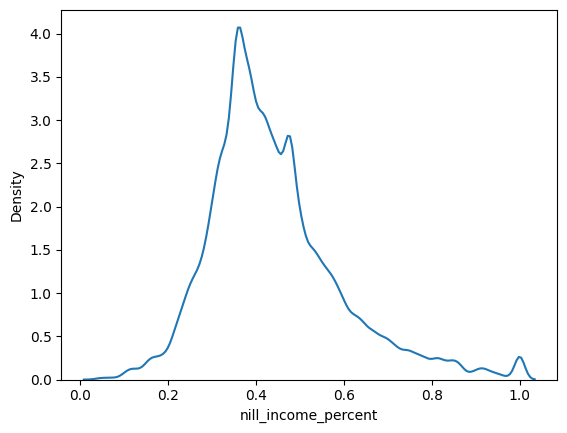

In [55]:
sns.kdeplot(census_consumers["nill_income_percent"])

/home/saurabhjhanjee/anaconda3/envs/ADS-BNPL/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='nill_income_percent_M'>

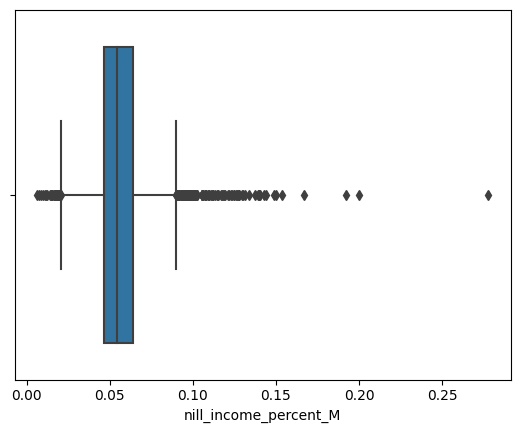

In [48]:
sns.boxplot(census["nill_income_percent_M"])

# According to my research, there are actually only 21 people living in 6628, so this is highly confusing. Clearly it is an outlier though.

In [52]:
Q3 = np.quantile(census["nill_income_percent_M"], 0.75)
Q1 = np.quantile(census["nill_income_percent_M"], 0.25)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
upper_limit



0.0899298044316664

In [53]:
Q3 = np.quantile(census["nill_income_percent_F"], 0.75)
Q1 = np.quantile(census["nill_income_percent_F"], 0.25)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
upper_limit


0.1271447539479093

Hence we will clamp these values to 0.15 and scale them back up

In [54]:
census_consumers["nill_income_percent"] = census_consumers["nill_income_percent"].clip(upper=0.15)/0.15

In [25]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


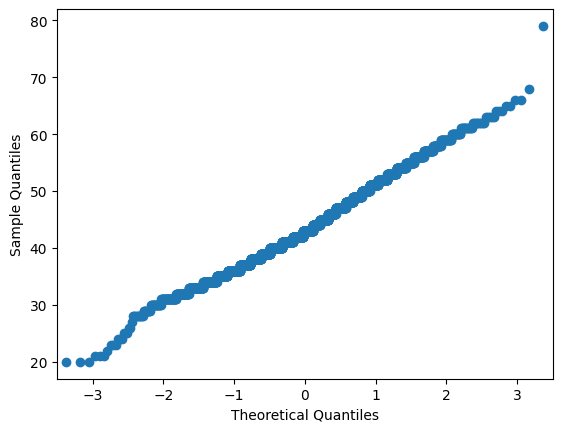

In [26]:
sm.qqplot(census["Median_age_persons"])
plt.show()


Looks kinda normal, so we standardise

In [27]:
census["Median_age_persons"] = (census["Median_age_persons"] - census["Median_age_persons"].mean() ) / census["Median_age_persons"].std()



In [28]:
# census_consumers["yr 12 completion"] = census_consumers[["gender", "comp_Yr_12_eq_percent_M", "comp_Yr_12_eq_percent_F"]].apply(lambda x: x["comp_Yr_12_eq_percent_" + ("M", "F")[["gender"] == "Female"]], axis=1)

In [29]:
# len(df)

My sad attempts at trying to fix the model below

In [30]:




# def train(df, census_consumers, merchants):
#     ENCODED_COLS = ["gender", "sector_tags", "revenue_band"]
#     SCALED_COLS = ["yr 12 completion", "house_repay_to_income", "Median_age_persons", "Median_tot_prsnl_inc_weekly", "Median_mortgage_repay_monthly", "take_rate"]
#     model = SGDRegressor()
#     encoder = OneHotEncoder()
#     scaler = StandardScaler()
#     i = 0
#     df = df.sample(frac=1)
#     interval = int(1e5)
#     test_size = int(1e5)
#     while i < len(df):
#         print(f"Training Sample: {i}-{min(i+interval, len(df)-test_size)}")
#         df_merged = df[i:min(i+interval, len(df)-test_size)].merge(census_consumers, on=["postcode"]).merge(merchants, on=["merchant_abn"]).replace([np.inf, -np.inf], np.nan).dropna()
#         i += interval
#         X, y = get_features_and_labels(df_merged, encoder, scaler, ENCODED_COLS, SCALED_COLS)
#         model.partial_fit(X, y)
#     test_df = df[-test_size:].merge(census_consumers, on=["postcode"]).merge(merchants, on=["merchant_abn"]).replace([np.inf, -np.inf], np.nan).dropna()
#     print(f"Test Score: {model.score(*get_features_and_labels(test_df, encoder, scaler, ENCODED_COLS, SCALED_COLS, train=False))}")

# def get_features_and_labels(df, encoder, scaler, ENCODED_COLS, SCALED_COLS, train=True):
#         X = df[["gender", "yr 12 completion", "house_repay_to_income", "Median_age_persons", "Median_tot_prsnl_inc_weekly", "Median_mortgage_repay_monthly", "sector_tags", "revenue_band", "take_rate"]]
#         X["take_rate"] = pd.to_numeric(X["take_rate"])
#         X["house_repay_to_income"] = pd.to_numeric(X["house_repay_to_income"])
#         scaled_columns =  scaler.fit_transform(X[SCALED_COLS]) if train else scaler.transform(X[SCALED_COLS])
#         encoded_columns =  encoder.fit_transform(X[ENCODED_COLS]) if train else encoder.transform(X[ENCODED_COLS])
#         X = np.concatenate([scaled_columns, encoded_columns], axis=1)
#         y = df["dollar_value"]
#         return X, y





In [31]:
# train(df, census_consumers, merchants)

In [32]:
# df_merged.count()

In [33]:
# len(X)

In [34]:
# X = X.to_pandas()

In [35]:
# y = y.to_pandas()

In [36]:
# type(X)

In [37]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [38]:
# model = ElasticNet()
# model.fit(X_train, y_train)

In [39]:
# model.score(X_test, y_test)